### Импорт библиотек и обеспечение воспроизводимости кода

In [ ]:
import numpy as np

import random

import os

from skimage.io import imread
from skimage.transform import resize

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from IPython.display import clear_output

import seaborn as sns
sns.set(style='whitegrid', font_scale=1.2)

import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim

from time import time

import pickle

import pandas as pd

from collections import defaultdict

In [ ]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(18)

### Данные

In [ ]:
!gdown https://drive.google.com/u/0/uc?id=1jRXrPJ2b8uUUOs7JuAvhWyaQmg2Zwxqw -O PH2Dataset.rar

Downloading...
From: https://drive.google.com/u/0/uc?id=1jRXrPJ2b8uUUOs7JuAvhWyaQmg2Zwxqw
To: /content/PH2Dataset.rar
100% 116M/116M [00:01<00:00, 79.4MB/s]


In [ ]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

In [ ]:
images = []
lesions = []
root = 'PH2Dataset'
for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
  if root.endswith('_Dermoscopic_Image'):
    images.append(imread(os.path.join(root, files[0])))
  if root.endswith('_lesion'):
    lesions.append(imread(os.path.join(root, files[0])))

In [ ]:
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True) for x in images]
X = np.array(X, np.float32)
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]
Y = np.array(Y, np.float32)

In [ ]:
print(f'Всего {len(X)} изображений')

Всего 200 изображений


In [ ]:
def plot_random_images(n):
  plt.figure(figsize=(2 * n, 4))
  image_idcs = np.random.choice(len(X), size=n, replace=False)
  for i in range(n):
    plt.subplot(2, n, i+1)
    plt.axis("off")
    plt.imshow(X[image_idcs[i]])
    plt.subplot(2, n, i+n+1)
    plt.axis("off")
    plt.imshow(Y[image_idcs[i]], cmap='gray')
  plt.show()

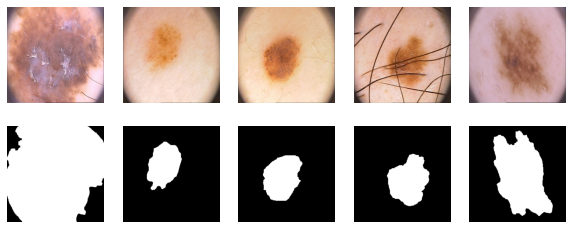

In [ ]:
plot_random_images(5)

In [ ]:
idcs = np.random.choice(len(X), len(X), False)
train, val, test = np.split(idcs, [100, 150])

In [ ]:
train_loader = DataLoader(list(zip(np.rollaxis(X[train], 3, 1), Y[train, np.newaxis])), batch_size=9, shuffle=True, drop_last=True)
val_loader = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])), batch_size=10, shuffle=True)
test_loader = DataLoader(list(zip(np.rollaxis(X[test], 3, 1), Y[test, np.newaxis])), batch_size=10, shuffle=False)

### Архитектуры

#### SegNet

In [ ]:
class SegNet(nn.Module):
  def __init__(self):
    super().__init__()

    self.enc_conv1 = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
        nn.BatchNorm2d(num_features=64),
        nn.ReLU(),
        nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
        nn.BatchNorm2d(num_features=64),
        nn.ReLU()
    )
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

    self.enc_conv2 = nn.Sequential(
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
        nn.BatchNorm2d(num_features=128),
        nn.ReLU(),
        nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
        nn.BatchNorm2d(num_features=128),
        nn.ReLU()
    )
    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

    self.enc_conv3 = nn.Sequential(
        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
        nn.BatchNorm2d(num_features=256),
        nn.ReLU(),
        nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
        nn.BatchNorm2d(num_features=256),
        nn.ReLU(),
        nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
        nn.BatchNorm2d(num_features=256),
        nn.ReLU()
    )
    self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

    self.enc_conv4 = nn.Sequential(
        nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
        nn.BatchNorm2d(num_features=512),
        nn.ReLU(),
        nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
        nn.BatchNorm2d(num_features=512),
        nn.ReLU(),
        nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
        nn.BatchNorm2d(num_features=512),
        nn.ReLU()
    )
    self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

    self.enc_conv5 = nn.Sequential(
        nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
        nn.BatchNorm2d(num_features=512),
        nn.ReLU(),
        nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
        nn.BatchNorm2d(num_features=512),
        nn.ReLU(),
        nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
        nn.BatchNorm2d(num_features=512),
        nn.ReLU()
    )
    self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

    self.upsample5 = nn.MaxUnpool2d(kernel_size=2, stride=2)
    self.dec_conv5 = nn.Sequential(
        nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
        nn.BatchNorm2d(num_features=512),
        nn.ReLU(),
        nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
        nn.BatchNorm2d(num_features=512),
        nn.ReLU(),
        nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
        nn.BatchNorm2d(num_features=512),
        nn.ReLU()
    )

    self.upsample4 = nn.MaxUnpool2d(kernel_size=2, stride=2)
    self.dec_conv4 = nn.Sequential(
        nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
        nn.BatchNorm2d(num_features=512),
        nn.ReLU(),
        nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
        nn.BatchNorm2d(num_features=512),
        nn.ReLU(),
        nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
        nn.BatchNorm2d(num_features=256),
        nn.ReLU()
    )

    self.upsample3 = nn.MaxUnpool2d(kernel_size=2, stride=2)
    self.dec_conv3 = nn.Sequential(
        nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
        nn.BatchNorm2d(num_features=256),
        nn.ReLU(),
        nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
        nn.BatchNorm2d(num_features=256),
        nn.ReLU(),
        nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
        nn.BatchNorm2d(num_features=128),
        nn.ReLU()
    )

    self.upsample2 = nn.MaxUnpool2d(kernel_size=2, stride=2)
    self.dec_conv2 = nn.Sequential(
        nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
        nn.BatchNorm2d(num_features=128),
        nn.ReLU(),
        nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
        nn.BatchNorm2d(num_features=64),
        nn.ReLU()
    )

    self.upsample1 = nn.MaxUnpool2d(kernel_size=2, stride=2)
    self.dec_conv1 = nn.Sequential(
        nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
        nn.BatchNorm2d(num_features=64),
        nn.ReLU(),
        nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, padding=1),
    )

  def forward(self, x):
    e1, idcs1 = self.pool1(self.enc_conv1(x))
    e2, idcs2 = self.pool2(self.enc_conv2(e1))
    e3, idcs3 = self.pool3(self.enc_conv3(e2))
    e4, idcs4 = self.pool4(self.enc_conv4(e3))
    e5, idcs5 = self.pool5(self.enc_conv5(e4))

    d5 = self.dec_conv5(self.upsample5(e5, idcs5))
    d4 = self.dec_conv4(self.upsample4(d5, idcs4))
    d3 = self.dec_conv3(self.upsample3(d4, idcs3))
    d2 = self.dec_conv2(self.upsample2(d3, idcs2))
    d1 = self.dec_conv1(self.upsample1(d2, idcs1))
    
    return d1

#### U-Net

In [ ]:
def double_conv(in_channels, out_channels):
  return nn.Sequential(
      nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding=1),
      nn.BatchNorm2d(out_channels),
      nn.ReLU(),
      nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, padding=1),
      nn.BatchNorm2d(out_channels),
      nn.ReLU()
  )

In [ ]:
class UNet(nn.Module):
  def __init__(self):
    super().__init__()

    self.max_pool_2x2 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.down_conv1 = double_conv(3, 64)
    self.down_conv2 = double_conv(64, 128)
    self.down_conv3 = double_conv(128, 256)
    self.down_conv4 = double_conv(256, 512)
    self.down_conv5 = double_conv(512, 1024) 

    self.upsample5 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=2, stride=2)
    self.up_conv5 = double_conv(1024, 512)
    self.upsample4 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=2, stride=2)
    self.up_conv4 = double_conv(512, 256)
    self.upsample3 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2)
    self.up_conv3 = double_conv(256, 128)
    self.upsample2 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2)
    self.up_conv2 = double_conv(128, 64)
    self.out = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1)

  def forward(self, x):
    x1 = self.down_conv1(x)
    x2 = self.max_pool_2x2(x1)
    x3 = self.down_conv2(x2)
    x4 = self.max_pool_2x2(x3)
    x5 = self.down_conv3(x4)
    x6 = self.max_pool_2x2(x5)
    x7 = self.down_conv4(x6)
    x8 = self.max_pool_2x2(x7)
    x9 = self.down_conv5(x8)

    x = self.upsample5(x9)
    x = self.up_conv5(torch.cat([x7, x], dim=1))
    x = self.upsample4(x)
    x = self.up_conv4(torch.cat([x5, x], dim=1))
    x = self.upsample3(x)
    x = self.up_conv3(torch.cat([x3, x], dim=1))
    x = self.upsample2(x)
    x = self.up_conv2(torch.cat([x1, x], dim=1))
    x = self.out(x)
    return x

### Метрика

$\text{IoU} = \frac{\text{target } \cap \text{ prediction}}{\text{target } \cup \text{ prediction}}$

In [ ]:
def iou(outputs, labels):
    outputs = outputs.squeeze(1).byte()
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-4
    intersection = (outputs & labels).float().sum((1, 2))
    union = (outputs | labels).float().sum((1, 2))
    iou = (intersection + SMOOTH) / (union + SMOOTH)
    return iou

### Функции потерь

[**BCE loss**](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits)

$\hat{y} - \hat{y}y + \log\left(1+\exp(-\hat{y})\right)$ 

Чтобы обеспечить стабильность и избежать переполнения в $\exp(-\hat{y})$ при $\hat{y} < 0$, используется эквивалентная функция:

$\max(\hat{y}, 0) - \hat{y}y + \log(1 + \exp^{-|\hat{y}|})$ 

In [ ]:
def bce_loss(y_real, y_pred):
  return torch.mean(torch.clamp(y_pred, min=0) - y_pred * y_real + torch.log(1 + torch.exp(-torch.abs(y_pred))))

**DICE coefficient**

$\text{D(X,Y)}=\frac{2 |X \cap Y|}{|X|+|Y|}$

**DICE loss**

$1 - \sum_i\frac{2 X_i Y_i}{X_i + Y_i}$

In [ ]:
def dice_loss(y_real, y_pred):
  y_pred = torch.sigmoid(y_pred)
  SMOOTH = 1e-4
  num = 2 * torch.sum(y_real * y_pred, (1, 2, 3))
  den = torch.sum(y_real + y_pred, (1, 2, 3))
  loss = 1 - torch.mean((num + SMOOTH) / (den + SMOOTH))
  return loss 

**Focal loss**

$-\left[\left(1-\sigma(\hat{y})\right)^\gamma y\log\sigma(\hat{y}) + (1-y)\log(1-\sigma(\hat{y}))\right].$

In [ ]:
def focal_loss(y_real, y_pred, eps=1e-4, gamma=2):
    prob = torch.sigmoid(y_pred)
    prob = torch.clamp(prob, min=eps, max=1 - eps)
    loss_p1 = -(torch.pow(1 - prob, gamma) * y_real).detach() * torch.log(prob)
    loss_p2 = -(1 - y_real) * torch.log(1 - prob)
    loss = torch.mean(loss_p1 + loss_p2)
    return loss

### Тренировка

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
loaders = {'train': train_loader, 'val': val_loader}

In [ ]:
def train(model, optimizer, scheduler, loss_func, metric, epochs):
  losses = {'train': [], 'val': []}
  scores = {'train': [], 'val': []}
  best_model = {}
  x_val, y_val = next(iter(loaders['val']))[:6]
  row_titles = ['Dermoscopic Image', 'Lesion Real', 'Lesion Predicted']
  training_time = 0
  for epoch in range(epochs):
    tic = time()
    for phase, dataloader in loaders.items():
      avg_loss = 0.0
      avg_score = 0.0
      if phase == 'train':
        model.train()
      else:
        model.eval()
      for x_batch, y_batch in dataloader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        if phase == 'train':
          optimizer.zero_grad()
          y_pred = model(x_batch)
        else:
          with torch.no_grad():
            y_pred = model(x_batch)
        loss = loss_func(y_batch, y_pred)
        avg_loss += loss.item() / len(dataloader)
        score = metric(torch.where(torch.sigmoid(y_pred.detach()) > 0.5, 1, 0), y_batch).mean().item()
        avg_score += score / len(dataloader)
        if phase == 'train':
          loss.backward()
          optimizer.step()
        x_batch, y_batch = x_batch.cpu(), y_batch.cpu()
      if phase == 'train':
        toc = time()
        training_time += toc - tic
      if phase == 'val' and ('val_loss' not in best_model or best_model['val_loss'] > avg_loss):
        best_model['val_loss'] = avg_loss
        best_model['train_loss'] = losses['train'][-1]
        best_model['val_score'] = avg_score
        best_model['train_score'] = scores['train'][-1]
        best_model['state'] = {k: v.cpu() for k, v in model.state_dict().items()} 
        best_model['epochs'] = epoch
        best_model['training_time'] = training_time
      losses[phase].append(avg_loss)
      scores[phase].append(avg_score)
    scheduler.step()
      
    model.eval()
    y_hat = torch.where(torch.sigmoid(model(x_val.to(device)).detach().cpu()) > 0.5, 1, 0)
    clear_output(wait=True)
    fig, big_axes = plt.subplots(nrows=3, ncols=1, figsize=(15, 6))
    for big_ax, row_title in zip(big_axes, row_titles):
      big_ax.set_title(row_title)
      big_ax.set_axis_off()
    for i in range(1, 7):
      ax0i = fig.add_subplot(3, 6, i)
      ax0i.imshow(np.rollaxis(x_val[i].numpy(), 0, 3))
      ax0i.set_axis_off()
      ax1i = fig.add_subplot(3, 6, 6+i)
      ax1i.imshow(y_val[i, 0], cmap='gray')
      ax1i.set_axis_off()
      ax2i = fig.add_subplot(3, 6, 12+i)
      ax2i.imshow(y_hat[i, 0], cmap='gray')
      ax2i.set_axis_off()
    train_loss = losses['train'][-1]
    val_loss = losses['val'][-1]
    train_score = scores['train'][-1]
    val_score = scores['val'][-1]
    plt.suptitle(f'{epoch+1}/{epochs} train_loss: {round(train_loss, 4)} val_loss: {round(val_loss, 4)} train_score: {round(train_score, 4)} val_score: {round(val_score, 4)}', 
                 fontsize=14)
    plt.show()
  return {'losses': losses, 'scores': scores, 'best_model': best_model}

In [ ]:
def plot_losses_and_scores(epoches, history, suptitle):
  losses = history['losses']
  scores = history['scores']
  bm = history['best_model']
  fig, axes = plt.subplots(1, 2, figsize=(23, 6))
  for ax, ls, ylabel in zip(axes, [losses, scores], ['loss', 'score']):
    ax.plot(range(1, epoches + 1), ls['train'], zorder=1, label='train')
    ax.plot(range(1, epoches + 1), ls['val'], zorder=2, label='validation')
    ax.scatter(bm['epochs']+1, bm['val_' + ylabel], c='red', zorder=3, label='best model')
    ax.set_xlabel('epoch')
    ax.set_ylabel(ylabel)
    ax.legend()
  plt.suptitle(suptitle, fontsize=14)

In [ ]:
def best_model_results(history):
  bm = history['best_model']
  epoch = bm['epochs']
  training_time = bm['training_time']
  train_loss = bm['train_loss']
  val_loss = bm['val_loss']
  train_score = bm['train_score']
  val_score = bm['val_score']
  print(f'{epoch + 1} epoches of training in {int(training_time / 60)} minutes and {int(training_time % 60)} seconds')
  print(f'Train loss: {round(train_loss, 4)}, Validation loss: {round(val_loss, 4)}')
  print(f'Train score: {round(train_score, 4)}, Validation score: {round(val_score, 4)}')

### Инференс

In [ ]:
def predict(model, dataloader):
  model.eval()
  y_pred = []
  for x_batch, y_batch in dataloader:
    with torch.no_grad():
      y_pred.extend(torch.where(torch.sigmoid(model(x_batch.to(device)).cpu()) > 0.5, 1, 0))
  return y_pred

In [ ]:
def score_model(model, metric, dataloader):
  model.eval()
  scores = 0.0
  for x_batch, y_label in dataloader:
    with torch.no_grad():
      y_pred = torch.where(torch.sigmoid(model(x_batch.to(device)).cpu()) > 0.5, 1, 0)
    scores += metric(y_pred, y_label).mean().item()
  return scores / len(dataloader)

### Обучение

In [ ]:
test_scores = {}

#### SegNet и BCE loss

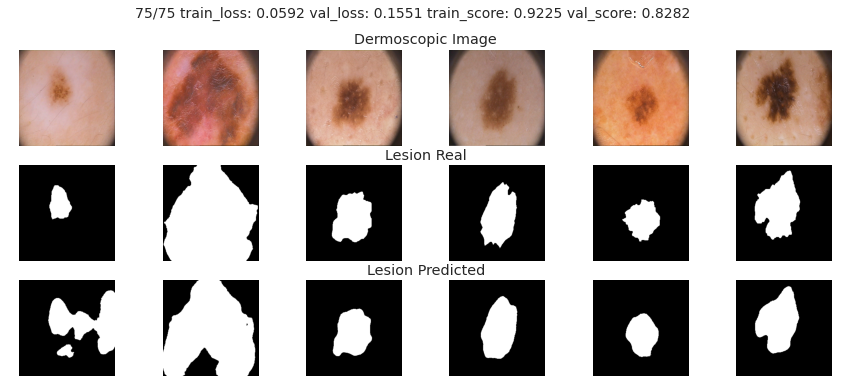

In [ ]:
segnet = SegNet().to(device)
optimizer = optim.AdamW(segnet.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=25)
epoches = 75
segnet_bce_history = train(segnet, optimizer, scheduler, bce_loss, iou, epoches)
segnet = segnet.cpu()

In [ ]:
with open('segnet_bce_history.pkl', 'wb') as segnet_bce_history_file:
  pickle.dump(segnet_bce_history, segnet_bce_history_file)

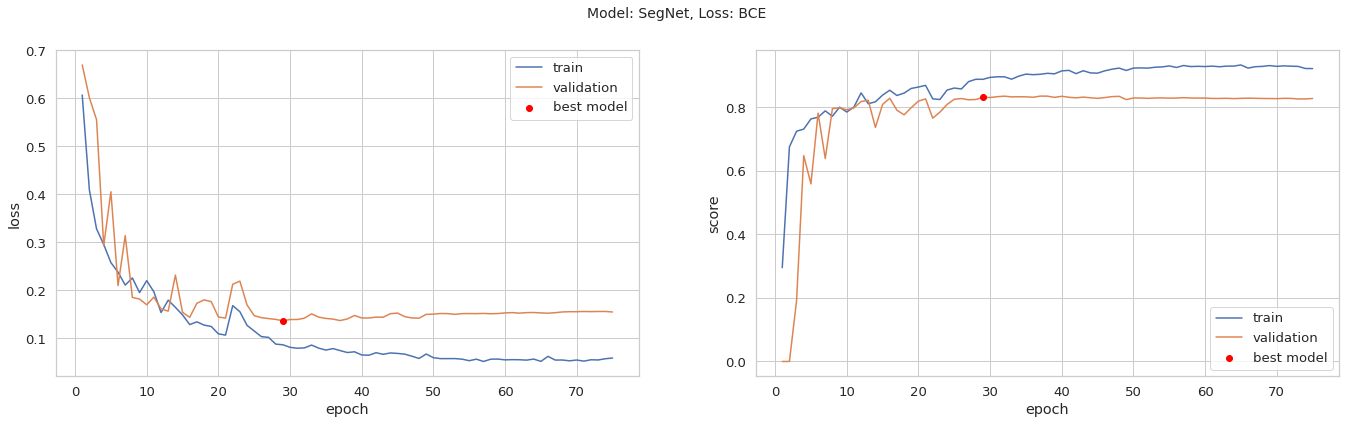

In [ ]:
plot_losses_and_scores(epoches, segnet_bce_history, 'Model: SegNet, Loss: BCE')

In [ ]:
best_model_results(segnet_bce_history)

29 epoches of training in 10 minutes and 2 seconds
Train loss: 0.0868, Validation loss: 0.1368
Train score: 0.8887, Validation score: 0.832


In [ ]:
best_model_segnet_bce = SegNet().to(device)
best_model_segnet_bce.load_state_dict(segnet_bce_history['best_model']['state'])
test_scores['SegNet_BCE'] = score_model(best_model_segnet_bce, iou, test_loader)
test_scores['SegNet_BCE']

0.8626944184303283

In [ ]:
torch.cuda.empty_cache()
!nvidia-smi

#### SegNet и DICE loss

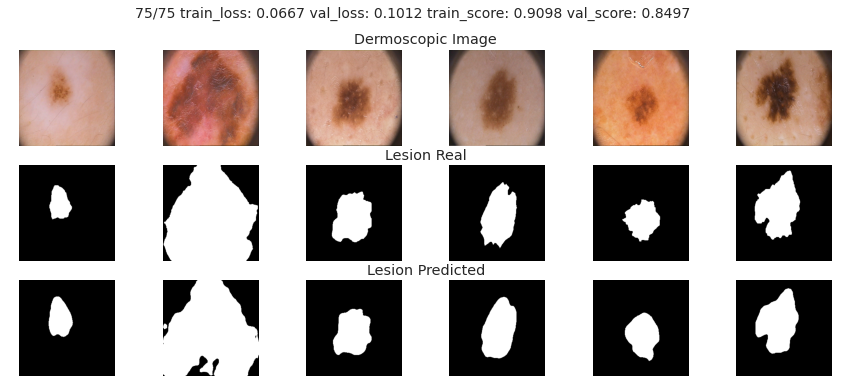

In [ ]:
segnet = SegNet().to(device)
optimizer = optim.AdamW(segnet.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=25)
epoches = 75
segnet_dice_history = train(segnet, optimizer, scheduler, dice_loss, iou, epoches)
segnet = segnet.cpu()

In [ ]:
with open('segnet_dice_history.pkl', 'wb') as segnet_dice_history_file:
  pickle.dump(segnet_dice_history, segnet_dice_history_file)

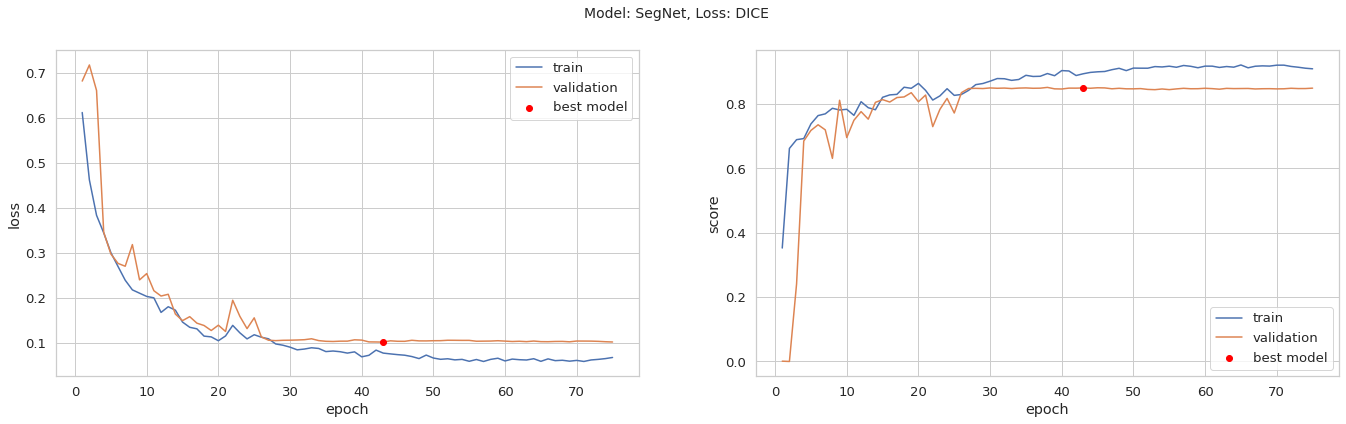

In [ ]:
plot_losses_and_scores(epoches, segnet_dice_history, 'Model: SegNet, Loss: DICE')

In [ ]:
best_model_results(segnet_dice_history)

43 epoches of training in 5 minutes and 43 seconds
Train loss: 0.0765, Validation loss: 0.101
Train score: 0.8944, Validation score: 0.8503


In [ ]:
best_model_segnet_dice = SegNet().to(device)
best_model_segnet_dice.load_state_dict(segnet_dice_history['best_model']['state'])
test_scores['SegNet_DICE'] = score_model(best_model_segnet_dice, iou, test_loader)
test_scores['SegNet_DICE']

0.8718178391456604

In [ ]:
torch.cuda.empty_cache()
!nvidia-smi

#### SegNet и Focal loss

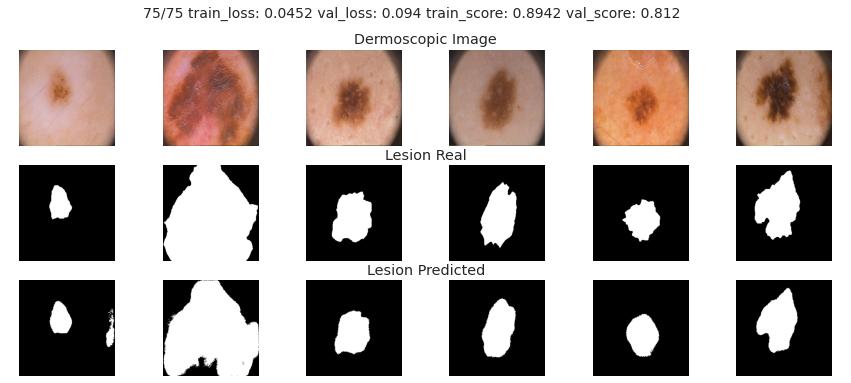

In [ ]:
segnet = SegNet().to(device)
optimizer = optim.AdamW(segnet.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=25)
epoches = 75
segnet_focal_history = train(segnet, optimizer, scheduler, focal_loss, iou, epoches)
segnet = segnet.cpu()

In [ ]:
with open('segnet_focal_history.pkl', 'wb') as segnet_focal_history_file:
  pickle.dump(segnet_focal_history, segnet_focal_history_file)

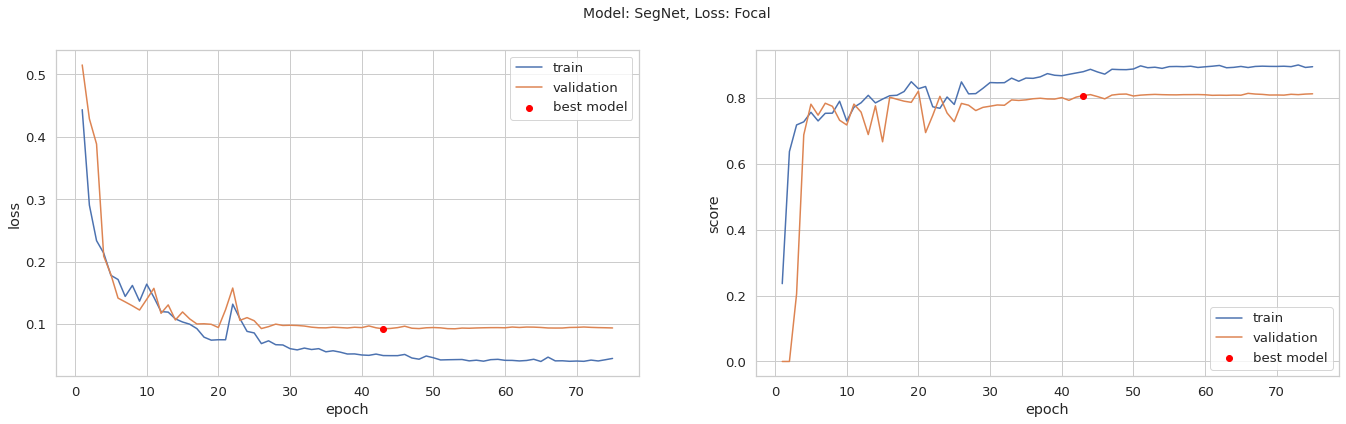

In [ ]:
plot_losses_and_scores(epoches, segnet_focal_history, 'Model: SegNet, Loss: Focal')

In [ ]:
best_model_results(segnet_focal_history)

43 epoches of training in 5 minutes and 22 seconds
Train loss: 0.0498, Validation loss: 0.0927
Train score: 0.8791, Validation score: 0.8068


In [ ]:
best_model_segnet_focal = SegNet().to(device)
best_model_segnet_focal.load_state_dict(segnet_focal_history['best_model']['state'])
test_scores['SegNet_Focal'] = score_model(best_model_segnet_focal, iou, test_loader)
test_scores['SegNet_Focal']

0.8237815499305725

In [ ]:
torch.cuda.empty_cache()
!nvidia-smi

#### U-Net и BCE loss

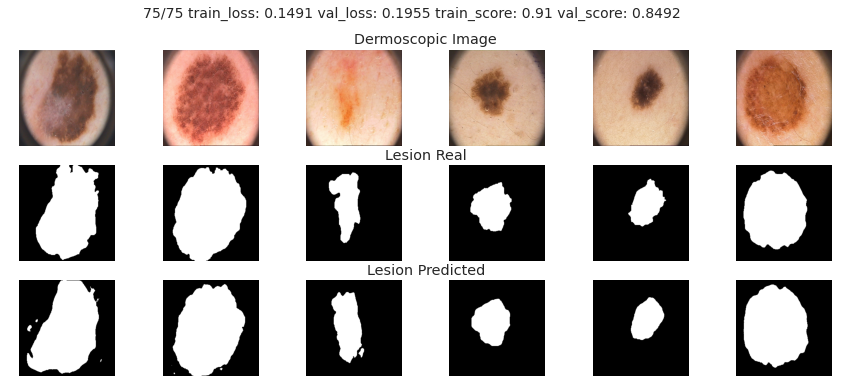

In [ ]:
unet = UNet().to(device)
optimizer = optim.AdamW(unet.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=25)
epoches = 75
unet_bce_history = train(unet, optimizer, scheduler, bce_loss, iou, epoches)
unet = unet.cpu()

In [ ]:
with open('unet_bce_history.pkl', 'wb') as unet_bce_history_file:
  pickle.dump(unet_bce_history, unet_bce_history_file)

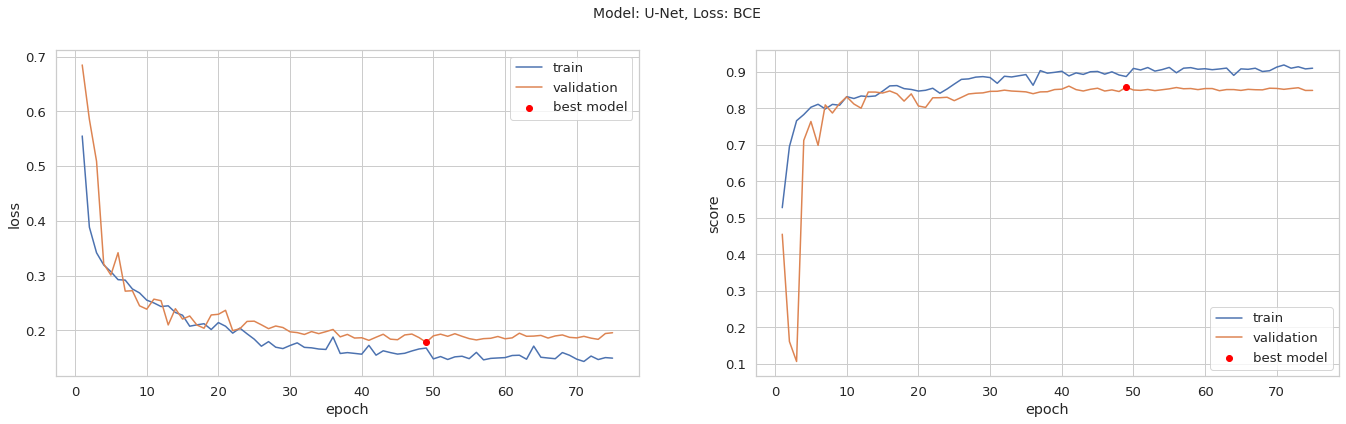

In [ ]:
plot_losses_and_scores(epoches, unet_bce_history, 'Model: U-Net, Loss: BCE')

In [ ]:
best_model_results(unet_bce_history)

49 epoches of training in 21 minutes and 17 seconds
Train loss: 0.1675, Validation loss: 0.178
Train score: 0.8872, Validation score: 0.8581


In [ ]:
best_model_unet_bce = UNet().to(device)
best_model_unet_bce.load_state_dict(unet_bce_history['best_model']['state'])
test_scores['UNet_BCE'] = score_model(best_model_unet_bce, iou, test_loader)
test_scores['UNet_BCE']

0.887034249305725

In [ ]:
torch.cuda.empty_cache()
!nvidia-smi

#### U-Net и DICE Loss

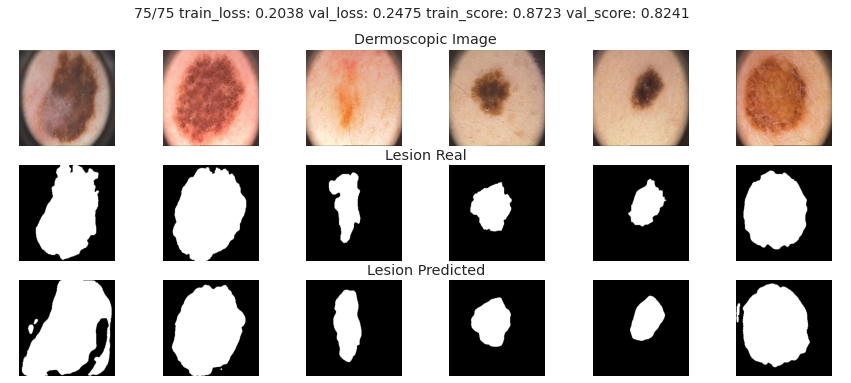

In [ ]:
unet = UNet().to(device)
optimizer = optim.AdamW(unet.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=25)
epoches = 75
unet_dice_history = train(unet, optimizer, scheduler, dice_loss, iou, epoches)
unet = unet.cpu()

In [ ]:
with open('unet_dice_history.pkl', 'wb') as unet_dice_history_file:
  pickle.dump(unet_dice_history, unet_dice_history_file)

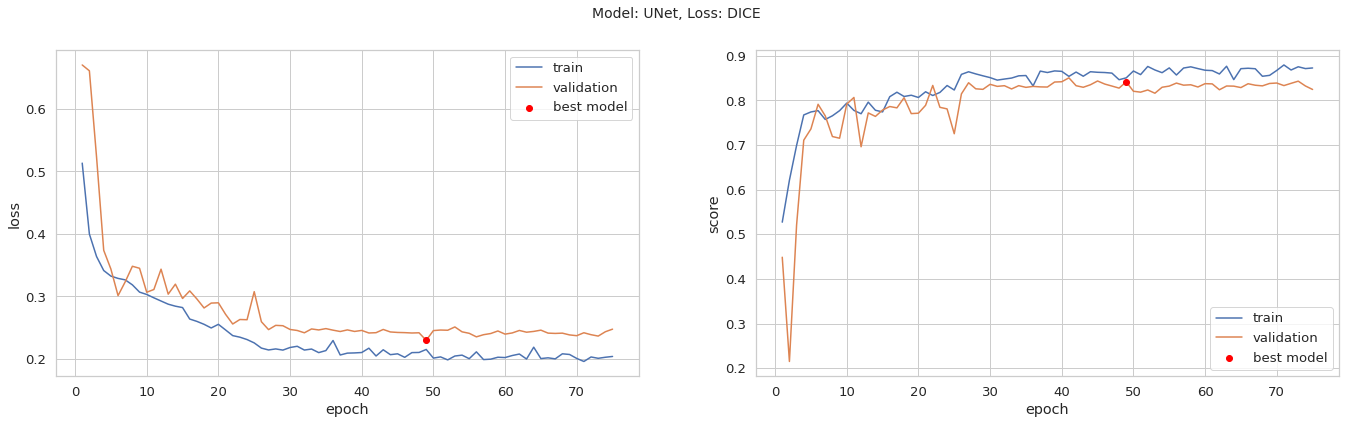

In [ ]:
plot_losses_and_scores(epoches, unet_dice_history, 'Model: UNet, Loss: DICE')

In [ ]:
best_model_results(unet_dice_history)

49 epoches of training in 9 minutes and 21 seconds
Train loss: 0.215, Validation loss: 0.2296
Train score: 0.8502, Validation score: 0.8412


In [ ]:
best_model_unet_dice = UNet().to(device)
best_model_unet_dice.load_state_dict(unet_dice_history['best_model']['state'])
test_scores['UNet_DICE'] = score_model(best_model_unet_dice, iou, test_loader)
test_scores['UNet_DICE']

0.8663169026374817

In [ ]:
torch.cuda.empty_cache()
!nvidia-smi

#### U-Net и Focal Loss

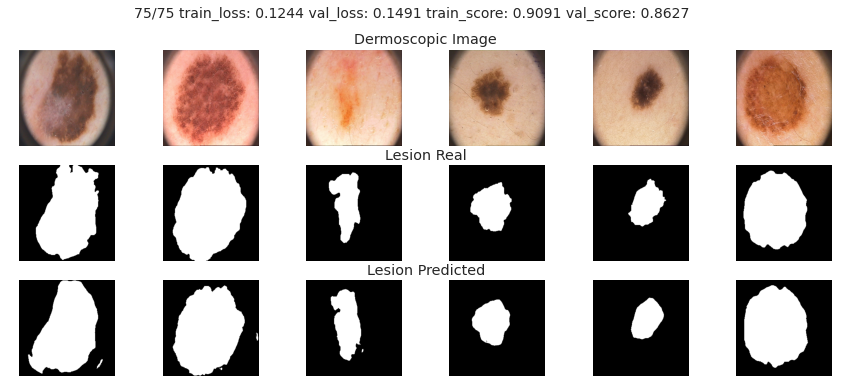

In [ ]:
unet = UNet().to(device)
optimizer = optim.AdamW(unet.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=25)
epoches = 75
unet_focal_history = train(unet, optimizer, scheduler, focal_loss, iou, epoches)
unet = unet.cpu()

In [ ]:
with open('unet_focal_history.pkl', 'wb') as unet_focal_history_file:
  pickle.dump(unet_focal_history, unet_focal_history_file)

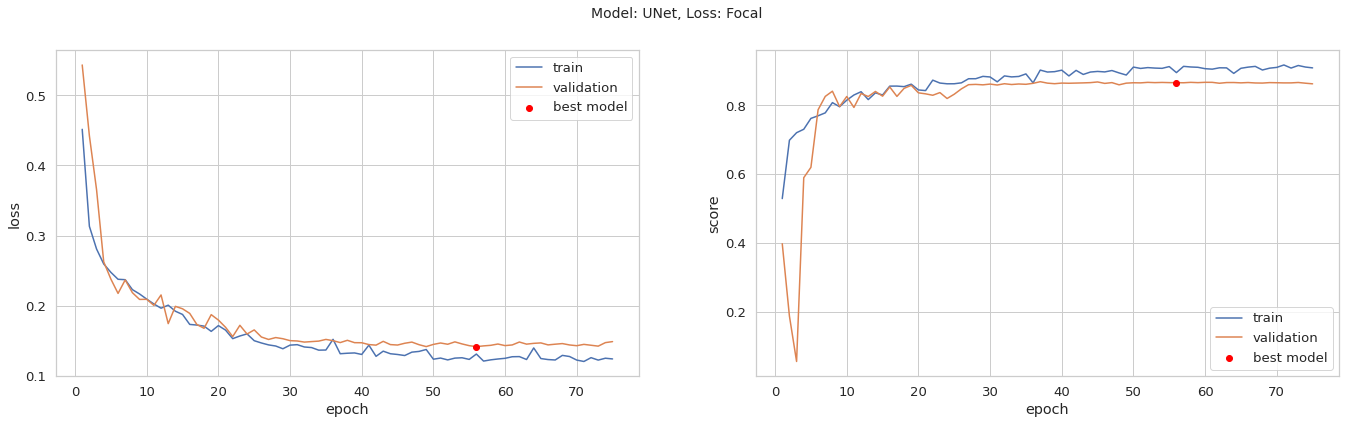

In [ ]:
plot_losses_and_scores(epoches, unet_focal_history, 'Model: UNet, Loss: Focal')

In [ ]:
best_model_results(unet_focal_history)

56 epoches of training in 10 minutes and 13 seconds
Train loss: 0.1313, Validation loss: 0.1418
Train score: 0.8954, Validation score: 0.8661


In [ ]:
best_model_unet_focal = UNet().to(device)
best_model_unet_focal.load_state_dict(unet_focal_history['best_model']['state'])
test_scores['UNet_Focal'] = score_model(best_model_unet_focal, iou, test_loader)
test_scores['UNet_Focal']

0.8798353195190429

In [ ]:
torch.cuda.empty_cache()
!nvidia-smi

### Функции для отображения результатов

In [ ]:
cp = sns.color_palette('deep')

In [ ]:
def plot_model_train_and_validation(history, suptitle):
  fig, axes = plt.subplots(1, 2, figsize=(23, 6))
  for ax, ls, ylabel in zip(axes, ['losses', 'scores'], ['loss', 'score']):
    for i, (label, h) in enumerate(history.items()):
      bm = h['best_model']
      ax.plot(range(1, 76), h[ls]['train'], zorder=1, label=label.split('_')[1]+'_train', linestyle='--', alpha=0.8, c=cp[i])
      ax.plot(range(1, 76), h[ls]['val'], zorder=2, label=label.split('_')[1]+'_val', c=cp[i])
      ax.scatter(bm['epochs']+1, bm['val_' + ylabel], c='red', zorder=3)
    ax.add_line(Line2D([], [], color='red', marker='o', linestyle='None', label='best model'))
    ax.set_xlabel('epoch')
    ax.set_ylabel(ylabel)
    ax.legend()
  plt.suptitle(suptitle)

In [ ]:
def best_model_scores(history):
  data = defaultdict(list)
  for name, h in history.items():
    data['model'].append(name)
    data['epoch'].append(h['best_model']['epochs'])
    data['train_score'].append(round(h['best_model']['train_score'], 4))
    data['val_score'].append(round(h['best_model']['val_score'], 4))
    data['test_score'].append(round(test_scores[name], 4))
  return pd.DataFrame.from_dict(data).set_index('model').sort_values(by='test_score')

In [ ]:
def plot_models_train_and_validation_by_loss_function(history):
  row_titles = ['BCE', 'DICE', 'Focal']
  fig, big_axes = plt.subplots(nrows=3, ncols=1, figsize=(15, 12))
  for big_ax, row_title in zip(big_axes, row_titles):
    big_ax.set_title(row_title)
    big_ax.set_axis_off()
  for i, lf in enumerate(history.keys()):
    for j, (ls, ylabel) in enumerate(zip(['losses', 'scores'], ['loss', 'score'])):
      ax = fig.add_subplot(3, 2, 2*i + j + 1)
      for k, model in enumerate(history[lf].keys()):
        bm = history[lf][model]['best_model']
        ax.plot(history[lf][model][ls]['train'], zorder=1, linestyle='--', c=cp[k], label=model)
        ax.plot(history[lf][model][ls]['val'], zorder=2, c=cp[k], label=model)
        ax.scatter(bm['epochs']+1, bm['val_' + ylabel], c='red', zorder=3)
      ax.set_xlabel('epoch')
      ax.set_ylabel(ylabel)
      ax.add_line(Line2D([], [], color='red', marker='o', linestyle='None', label='best model'))
      ax.legend()
  fig.tight_layout()
  plt.show()

In [ ]:
def plot_predictions(images, targets, predictions, n):
  column_titles = ['Dermoscopic Image', 'Lesion real', 'SegNet', 'UNet']
  fig, big_axes = plt.subplots(nrows=1, ncols=4, figsize=(12, n * 3))
  for big_ax, column_title in zip(big_axes, column_titles):
    big_ax.set_title(column_title)
    big_ax.set_axis_off()
  for i, j in enumerate(np.random.choice(50, size=n, replace=False)):
    axi1 = fig.add_subplot(n, 4, i*4 + 1)
    axi1.imshow(np.rollaxis(images[j].numpy(), 0, 3))
    axi1.set_axis_off()
    axi1.set_title('Dermoscopic Image')
    axi2 = fig.add_subplot(n, 4, i*4 + 2)
    axi2.imshow(targets[j][0], cmap='gray')
    axi2.set_axis_off()
    axi2.set_title('Lesion real')
    axi3 = fig.add_subplot(n, 4, i*4 + 3)
    axi3.imshow(predictions['SegNet'][j][0], cmap='gray')
    axi3.set_axis_off()
    axi3.set_title('SegNet')
    axi4 = fig.add_subplot(n, 4, i*4 + 4)
    axi4.imshow(predictions['UNet'][j][0], cmap='gray')
    axi4.set_axis_off()
    axi4.set_title('UNet')
  plt.show()

### Отчет

Были реализованы 2 архитектуры (SegNet и U-Net), каждая c 3 функциями потерь (BCE, DICE и Focal).

Всегда был одинаковый процесс обучения на 75 эпох с понижением lr равным 0.0001 в 0.1 раз каждые 25 эпох. Лучшей моделью считалась та, что давала самое низкое значение на функции потерь при валидации. Для обучения использовались батчи размера 9, а для валидации и теста - 10.

#### С какой функцией потерь лучше работает SegNet

In [ ]:
segnet_history = {'SegNet_BCE': segnet_bce_history,
                  'SegNet_DICE': segnet_dice_history,
                  'SegNet_Focal': segnet_focal_history}

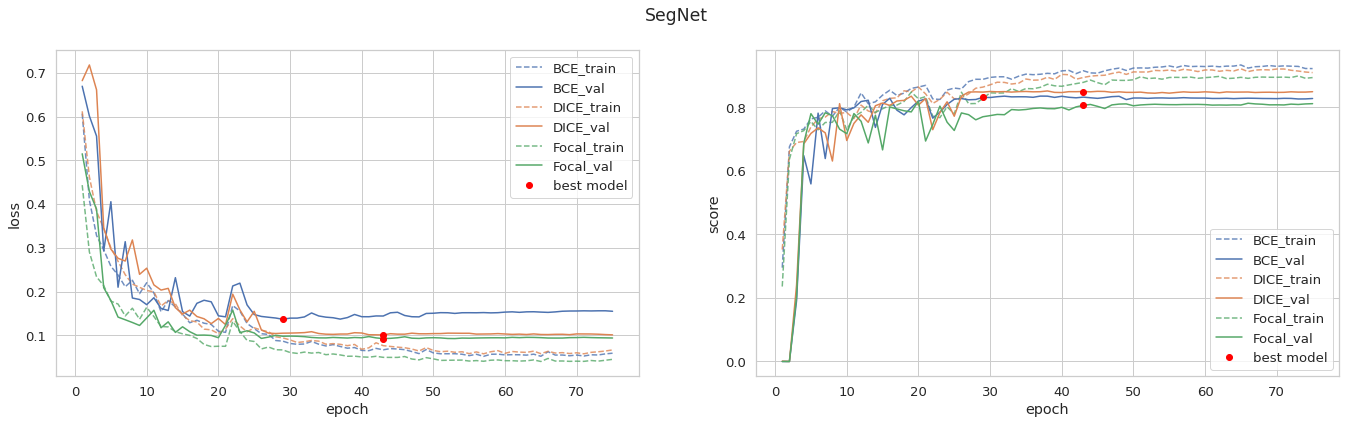

In [ ]:
plot_train_and_validation_history(segnet_history, 'SegNet')

In [ ]:
best_model_scores(segnet_history)

,epoch,train_score,val_score,test_score
model,,,,
SegNet_Focal,42,0.8791,0.8068,0.8238
SegNet_BCE,28,0.8887,0.8320,0.8627
SegNet_DICE,42,0.8944,0.8503,0.8718


Графики функций потерь примерно одинаковые - до 25 эпох происходит значительное снижение, после происходит выход на плато.

При DICE получились лучшие значения метрики на каждом наборе данных. При BCE удалось достичь близких к DICE значений метрики за меньшее количество эпох. Значения метрики при Focal значительнее проигрывают двум предыдущим.

#### С какой функцией потерь лучше работает U-Net

In [ ]:
unet_history = {'UNet_BCE': unet_bce_history,
                'UNet_DICE': unet_dice_history,
                'UNet_Focal': unet_focal_history}

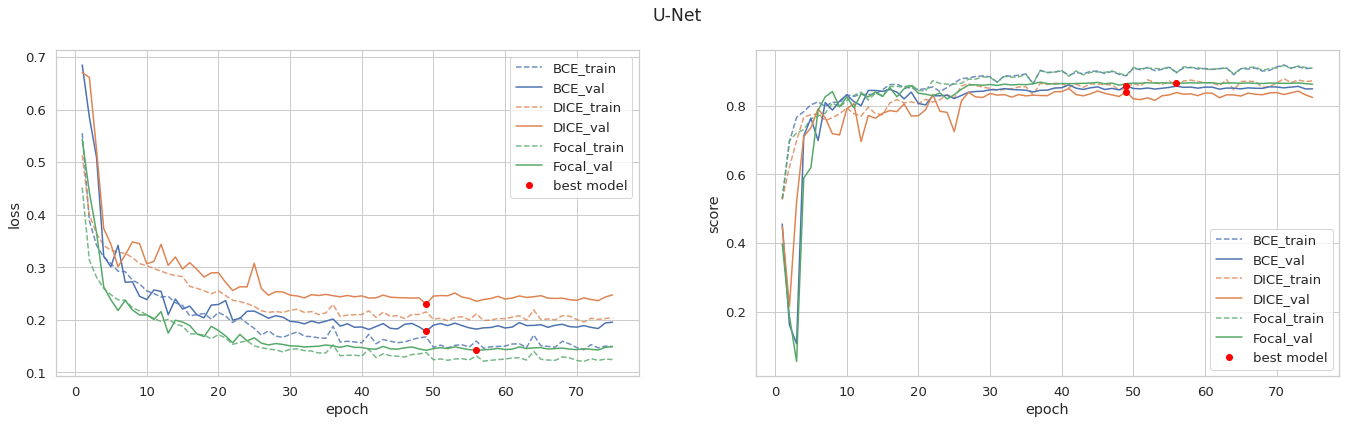

In [ ]:
plot_train_and_validation_history(unet_history, 'U-Net')

In [ ]:
best_model_scores(unet_history)

,epoch,train_score,val_score,test_score
model,,,,
UNet_DICE,48,0.8502,0.8412,0.8663
UNet_Focal,55,0.8954,0.8661,0.8798
UNet_BCE,48,0.8872,0.8581,0.8870


Графики функций потерь опять похожи - с 35 эпох значения перестают так сильно меняться как раньше.

Значения метрик при DICE сильнее отличаются от близких к друг-другу BCE и Focal. Несмотря на то, что на тесте значение метрики лучше при BCE, в качестве лучшей модели я бы все же выбрала Unet_Focal, так как разрыв между графиками на обучении и валидации чуть меньше, чем у UNet_BCE 

#### Сравнение SegNet и U-Net

In [ ]:
all_history = {'BCE': {'SegNet': segnet_bce_history, 'UNet': unet_bce_history},
           'DICE': {'SegNet': segnet_dice_history, 'UNet': unet_dice_history},
           'Focal': {'SegNet': segnet_focal_history, 'UNet': unet_focal_history}}

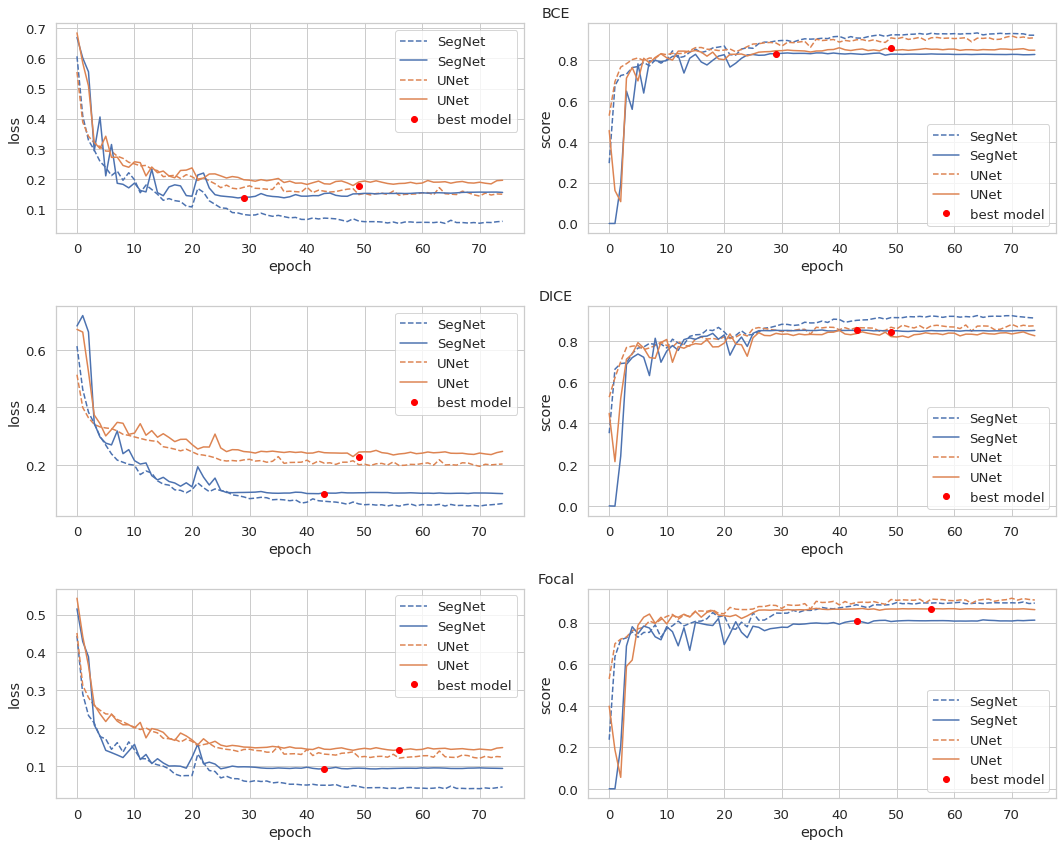

In [ ]:
plot_models_train_and_validation_by_loss_function(all_history)

In [ ]:
segnet_n_params = sum(p.numel() for p in SegNet().parameters())
unet_n_params = sum(p.numel() for p in UNet().parameters())
print(f'{segnet_n_params} параметров в SegNet и {unet_n_params} параметров в UNet')

29443585 параметров в SegNet и 31043521 параметров в UNet


In [ ]:
best_model_scores({**segnet_history, **unet_history})

,epoch,train_score,val_score,test_score
model,,,,
SegNet_Focal,42,0.8791,0.8068,0.8238
SegNet_BCE,28,0.8887,0.8320,0.8627
UNet_DICE,48,0.8502,0.8412,0.8663
SegNet_DICE,42,0.8944,0.8503,0.8718
UNet_Focal,55,0.8954,0.8661,0.8798
UNet_BCE,48,0.8872,0.8581,0.8870


В U-Net больше параметров, поэтому вполне логично, что для обучения оптимальных моделей U-Net потребовалось больше эпох.

Интересно, что в то время, как график потерь SegNet ниже, график метрик у U-Net выше (за исключением DICE). Возможно, это связано с тем, что у SegNet для большего количества пикселей вероятности ближе к 0 или 1, а у U-Net обычно вероятности больше сосредоточены около 0.5. 

Теперь сравним предсказания двух лучших моделей с реальной разметкой

In [ ]:
segnet_bm = SegNet().to(device)
segnet_bm.load_state_dict(segnet_dice_history['best_model']['state'])
unet_bm = UNet().to(device)
unet_bm.load_state_dict(unet_focal_history['best_model']['state'])

In [ ]:
images = []
targets = []
for x_batch, y_batch in test_loader:
  images.extend(x_batch)
  targets.extend(y_batch)
predictions = {}
predictions['SegNet'] = predict(segnet_bm, test_loader)
predictions['UNet'] = predict(unet_bm, test_loader)

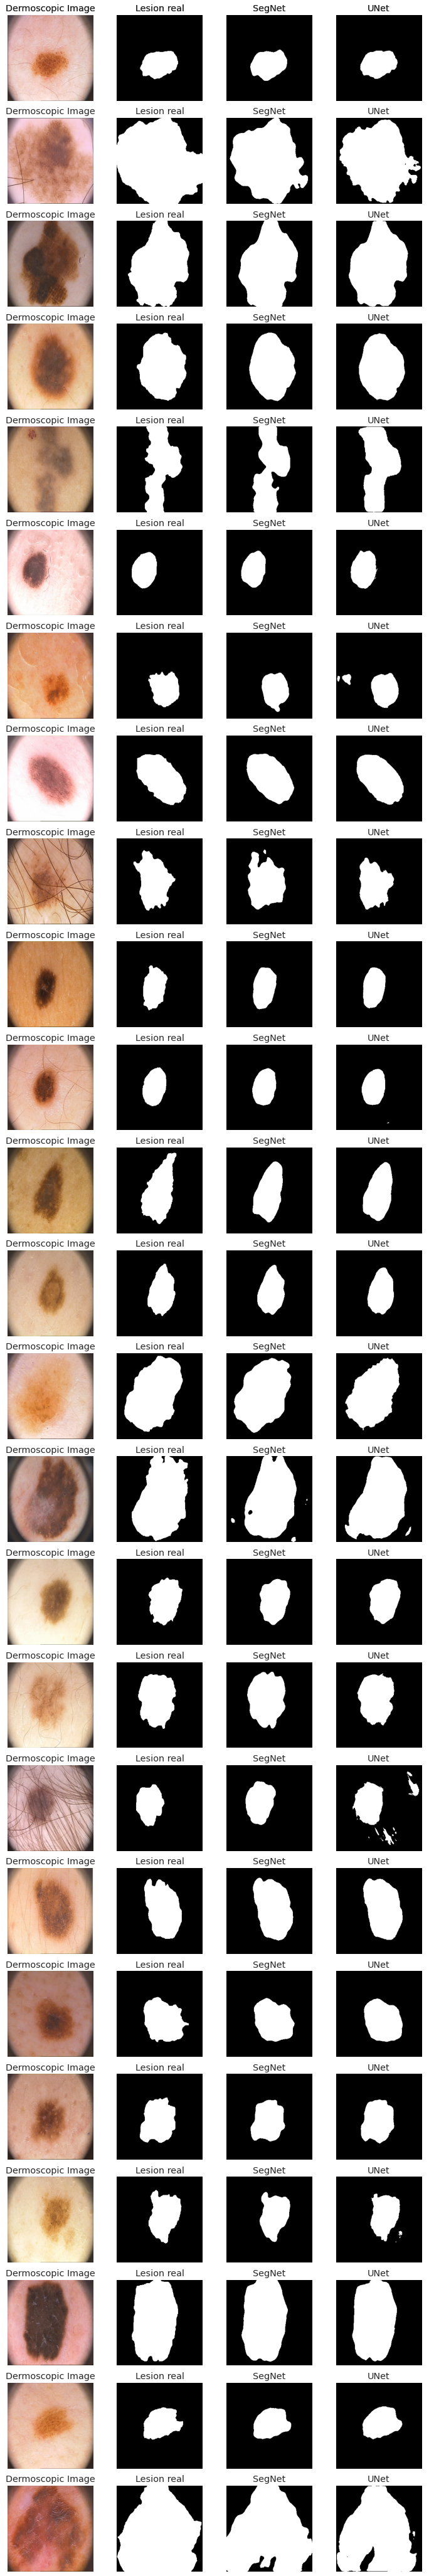

In [ ]:
plot_predictions(images, targets, predictions, 25)

В целом модели всегда правильно выделяют родинку или меланому, но не так хорошо ее границы. Иногда сегментации моделей лучше, чем реальная разметка. В одних случаях хорошо работает SegNet , в других - U-Net. Может стоило бы попробовать ансамблировать эти модели. 